# Analysing individual Recommenders

In [4]:
import config
from src.utils.MetricsEvaluator import MetricsEvaluator
from src.utils.RecommendationUtils import RecommendationUtils
from config import experiment_years
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools

data_stem = "../../scala-code/data/processed/"
rec_utils = RecommendationUtils(data_stem, 'RS')

yr = 2008

## Analysis constants and setup

In [7]:
CONST_min, CONST_max, CONST_stepsize = 5, 51, 5

k_list = range(CONST_min, CONST_max, CONST_stepsize)
params = list(itertools.product(k_list, [yr]))

In [8]:
metrics_evaluators = {}
models = ["CF-user_rec", "CF-user_artist"]
for (k_, yr_) in params:
    metrics_evaluators[(yr_, k_)] = MetricsEvaluator(models=models, year=yr_, k=k_, archive_size=100)

Initializing MetricsEvaluator for year:2008 and k:5


KeyboardInterrupt: 

In [ ]:
# metrics_evaluators[(yr_, 50)] = MetricsEvaluator(models=models, year=yr_, k=50)

In [ ]:
metrics_evaluators

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

metrics_to_plot = ['MAR', 'MAR_filtered', 'NaN_Prop', 'Pers', 'Nov', 'Cov', 'Fam']
pretty_names = {
    'MAR': 'Mean Average Recall',
    'MAR_filtered': 'Mean Average Recall (filtered)',
    'NaN_Prop': 'Proportion Unsuccessful Recommendation',
    'Pers': 'Personalization',
    'Nov': 'Novelty',
    'Cov': 'Coverage',
    'Fam': 'Familiarity',

    "CF-user_rec": "User-Record based Collaborative Filtering",
    "CF-user_artist": "User-Artist based Collaborative Filtering",
    "Pop": "Popular Recommender"
}

## functions: getting metrics for different list sizes

In [6]:
def parallel_evaluation(params_):
    k_, set_, model_, year_ = params_
    metric_eval = metrics_evaluators[(year_, k_)]
    recs_df = metric_eval.recommendation_dfs[(model_, set_)]
    recs_ = RecommendationUtils.get_recommendations_dict_from_single_df(df=recs_df)
    m = metric_eval.get_all_metrics(recs_, set_, k_)
    metrics_arr = []
    for metric_name in list(m.keys()):
        metrics_arr.append((k_, set_, metric_name, m[metric_name]))
    print(f"Completed: {params_}")
    return metrics_arr

def get_df_per_k_set(model: str, processes:int = config.num_cpu):
    k_list = range(CONST_min, CONST_max, CONST_stepsize)
    params_this_set = list(itertools.product(k_list, range(1,4), [model], [yr]))
    temp_data = Pool(processes).map(parallel_evaluation, params_this_set)
    data = []
    [data.append(y) for x in temp_data for y in x]
    df_ = pd.DataFrame(data, columns=['k', 'set', 'metric', 'val']).reset_index()
    df_ = df_[['k', 'metric', 'val']]\
        .groupby(['k', 'metric'])\
        .agg(['mean', 'std'])
    return df_.reset_index()

## Plotting function

In [7]:
from matplotlib.ticker import StrMethodFormatter

def plot_errorbars_single_recommender(data: pd.DataFrame, model: str, figsize:tuple=(15,5), yscale:str='linear'):
    fig = plt.figure(figsize=figsize, dpi=200)
#     fig.suptitle(f"{pretty_names[model]}\nmetrics errorbars at different list sizes")
    for metric in metrics_to_plot:
        df__ = data[data["metric"] == metric].reset_index()
        plt.errorbar(x=df__['k'],
                     y=df__['val']['mean'],
                     yerr=df__['val']['std'],
                     fmt='o-', elinewidth=0.5, markersize=3, linewidth=1, alpha=0.7,
                     label=pretty_names[metric])
    if yscale == 'linear':
        plt.ylim((-0.01,1.01))
    plt.yscale(yscale)

    plt.xlabel('Recommendation list size $k$')
    plt.ylabel("metric value (\\textbf{%s} scale)"% yscale)
    plt.ylim((-0.1,1.1))
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    
    plt.grid(True, which='both', linewidth=0.5, alpha=0.4)
    plt.legend(fontsize=7)
    plt.savefig(f'../images/single-recommenders/{model}_{yscale}.svg')

## User-Recording Collaborative Filtering

Completed: (5, 2, 'CF-user_rec', 2008)
Completed: (5, 1, 'CF-user_rec', 2008)
Completed: (5, 3, 'CF-user_rec', 2008)
Completed: (10, 2, 'CF-user_rec', 2008)
Completed: (10, 1, 'CF-user_rec', 2008)
Completed: (10, 3, 'CF-user_rec', 2008)
Completed: (15, 2, 'CF-user_rec', 2008)
Completed: (15, 1, 'CF-user_rec', 2008)
Completed: (15, 3, 'CF-user_rec', 2008)
Completed: (20, 2, 'CF-user_rec', 2008)
Completed: (20, 1, 'CF-user_rec', 2008)
Completed: (20, 3, 'CF-user_rec', 2008)
Completed: (25, 2, 'CF-user_rec', 2008)
Completed: (25, 1, 'CF-user_rec', 2008)
Completed: (25, 3, 'CF-user_rec', 2008)
Completed: (30, 2, 'CF-user_rec', 2008)
Completed: (30, 1, 'CF-user_rec', 2008)
Completed: (30, 3, 'CF-user_rec', 2008)
Completed: (35, 2, 'CF-user_rec', 2008)
Completed: (35, 1, 'CF-user_rec', 2008)
Completed: (35, 3, 'CF-user_rec', 2008)
Completed: (40, 1, 'CF-user_rec', 2008)
Completed: (40, 2, 'CF-user_rec', 2008)
Completed: (40, 3, 'CF-user_rec', 2008)
Completed: (45, 2, 'CF-user_rec', 2008)
Com

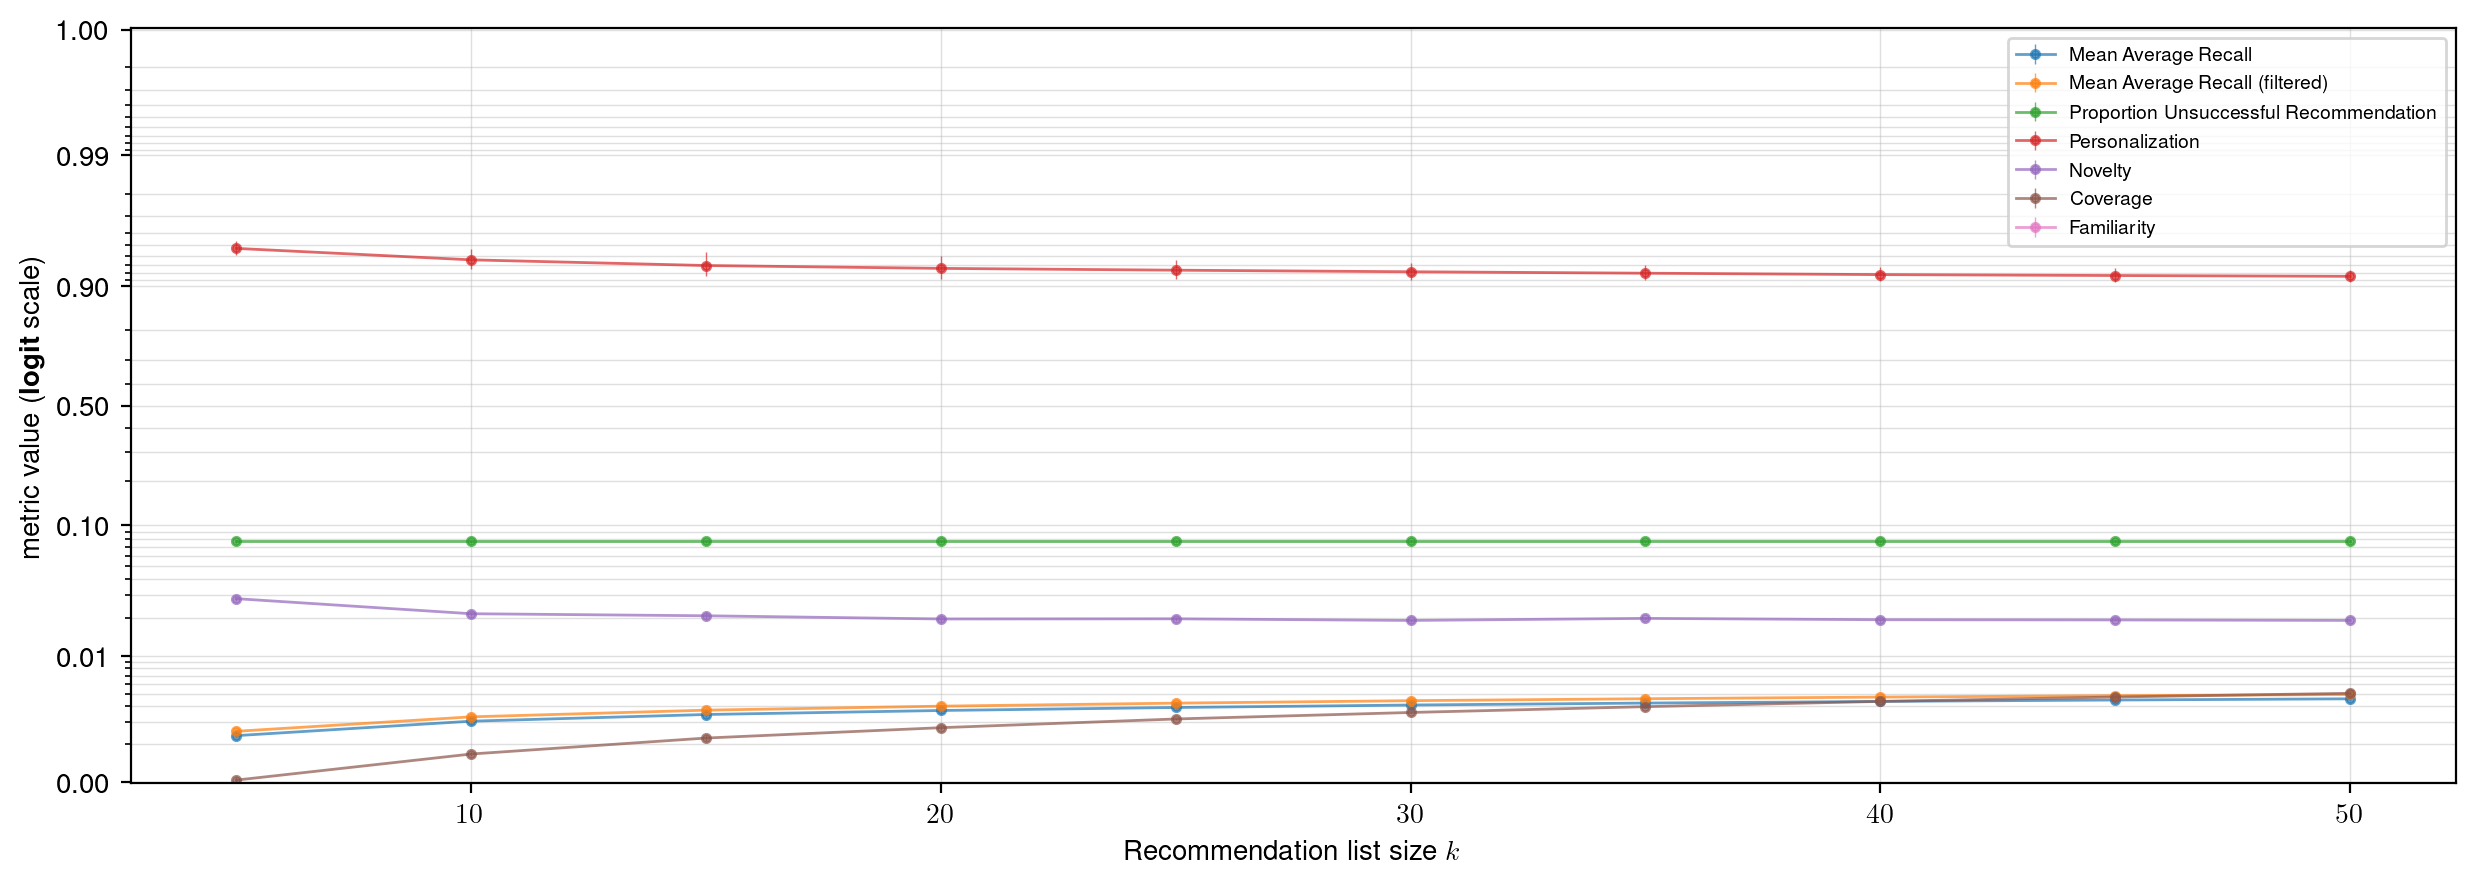

In [14]:
model_ = "CF-user_rec"
df_1 = get_df_per_k_set(model_)
plot_errorbars_single_recommender(df_2, model=model_, yscale='logit')

## User-Artist Collaborative Filtering

Completed: (5, 1, 'CF-user_artist', 2008)
Completed: (10, 2, 'CF-user_artist', 2008)
Completed: (5, 2, 'CF-user_artist', 2008)
Completed: (5, 3, 'CF-user_artist', 2008)
Completed: (10, 3, 'CF-user_artist', 2008)
Completed: (10, 1, 'CF-user_artist', 2008)
Completed: (15, 1, 'CF-user_artist', 2008)
Completed: (15, 3, 'CF-user_artist', 2008)
Completed: (15, 2, 'CF-user_artist', 2008)
Completed: (20, 1, 'CF-user_artist', 2008)
Completed: (25, 1, 'CF-user_artist', 2008)
Completed: (20, 2, 'CF-user_artist', 2008)
Completed: (25, 2, 'CF-user_artist', 2008)
Completed: (20, 3, 'CF-user_artist', 2008)
Completed: (25, 3, 'CF-user_artist', 2008)
Completed: (30, 2, 'CF-user_artist', 2008)
Completed: (30, 1, 'CF-user_artist', 2008)
Completed: (30, 3, 'CF-user_artist', 2008)
Completed: (35, 3, 'CF-user_artist', 2008)
Completed: (35, 1, 'CF-user_artist', 2008)
Completed: (40, 1, 'CF-user_artist', 2008)
Completed: (35, 2, 'CF-user_artist', 2008)
Completed: (40, 2, 'CF-user_artist', 2008)
Completed: (45

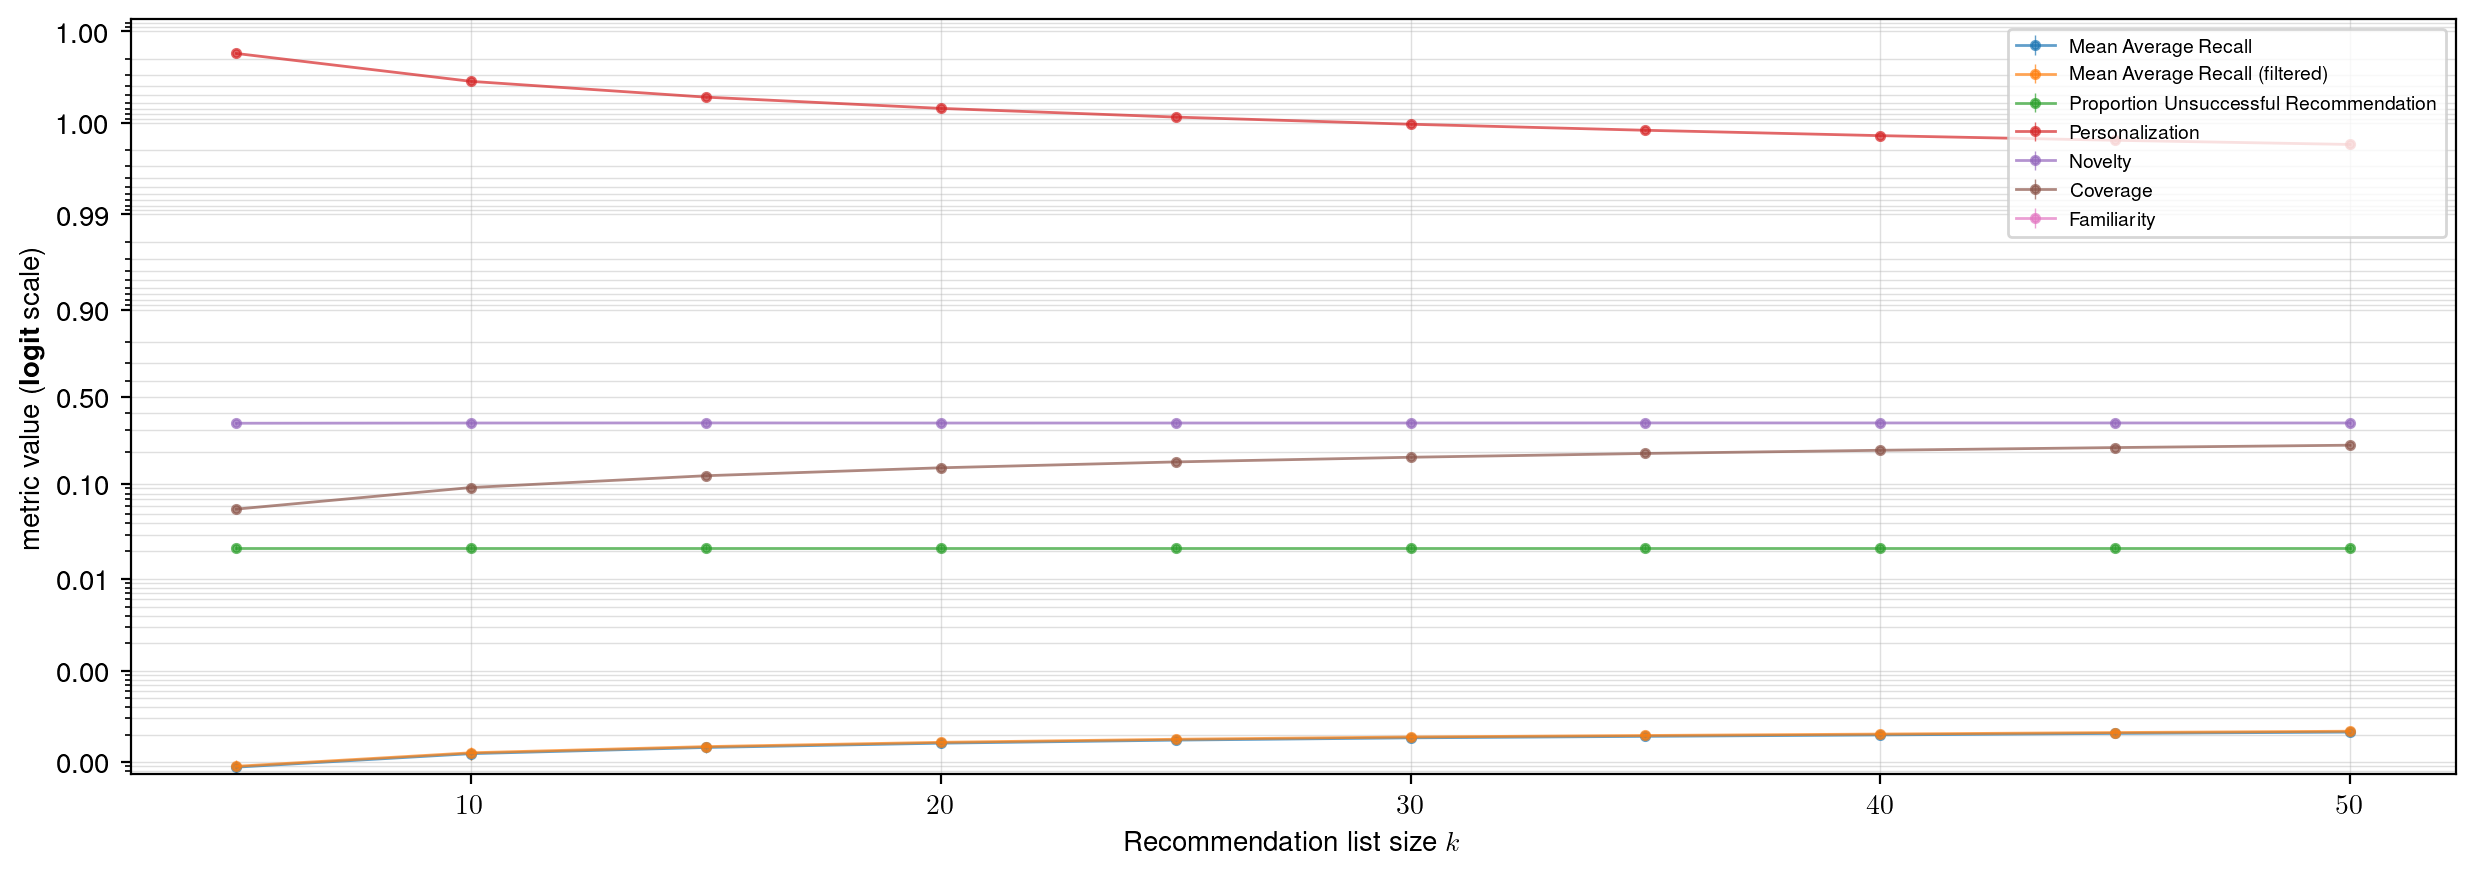

In [15]:
model_ = "CF-user_artist"
df_2 = get_df_per_k_set(model_, processes = 2)
plot_errorbars_single_recommender(df_2, model=model_, yscale='logit')

## Popular Recommender

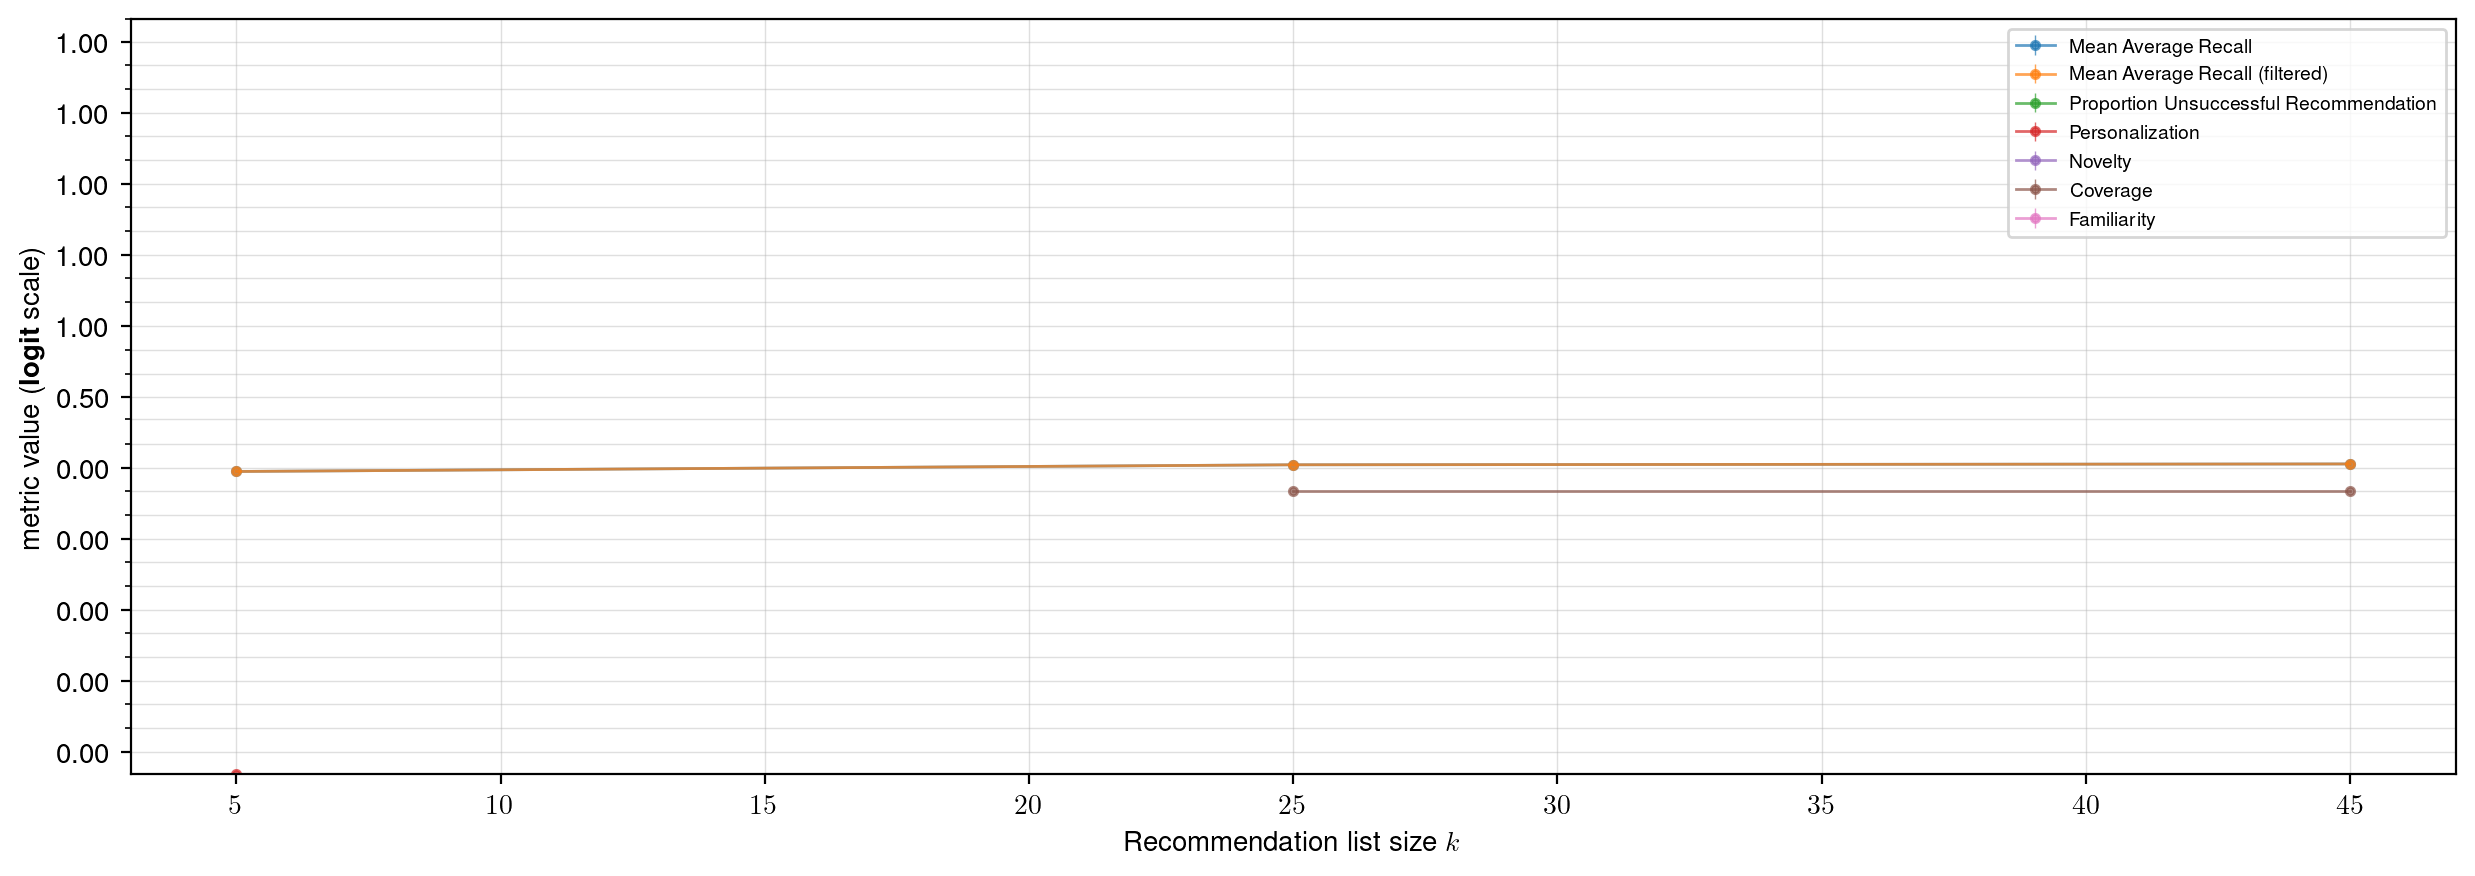

In [23]:
model_ = "Pop"
df = get_df_per_k_set(model_, processes = 5)
plot_errorbars_single_recommender(df, model=model_, yscale='logit')

In [24]:
print(df)

     k        metric           val          
                              mean       std
0    5           Cov  0.000000e+00  0.000000
1    5           Fam -1.000000e+00  0.000000
2    5           MAR  6.917263e-04  0.000036
3    5  MAR_filtered  6.917263e-04  0.000036
4    5      NaN_Prop  0.000000e+00  0.000000
5    5           Nov  0.000000e+00  0.000000
6    5          Pers  1.110223e-16  0.000000
7   25           Cov  1.000000e-04  0.000000
8   25           Fam -1.000000e+00  0.000000
9   25           MAR  1.327027e-03  0.000084
10  25  MAR_filtered  1.327027e-03  0.000084
11  25      NaN_Prop  0.000000e+00  0.000000
12  25           Nov  0.000000e+00  0.000000
13  25          Pers -2.220446e-16  0.000000
14  45           Cov  1.000000e-04  0.000000
15  45           Fam -1.000000e+00  0.000000
16  45           MAR  1.438544e-03  0.000083
17  45  MAR_filtered  1.438544e-03  0.000083
18  45      NaN_Prop  0.000000e+00  0.000000
19  45           Nov  0.000000e+00  0.000000
20  45    